In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=4e6a772019315669971867381192e847bb28e94aa339cef64bcac280e53d210b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=9abce481c83ddee443eb4474319dec7a20c088ec2b62aefd2c6d333a92f9feda
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

<ipython-input-36-b7dedd90a1c0>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load(MODEL_PATH1, map_location=torch.device('cuda' if torch.cuda.is_available

Please enter the file path to the image you want to try on lipstick:
/content/lady12.jpg
What color do you want to try on:
1. Punch - #dc3753
2. Rose - #e56d7e
3. Brick red - #8b160e
4. Dusty rose - #b8696a
5. Nude - #ccac9e
6. Royal blue - #313456
2


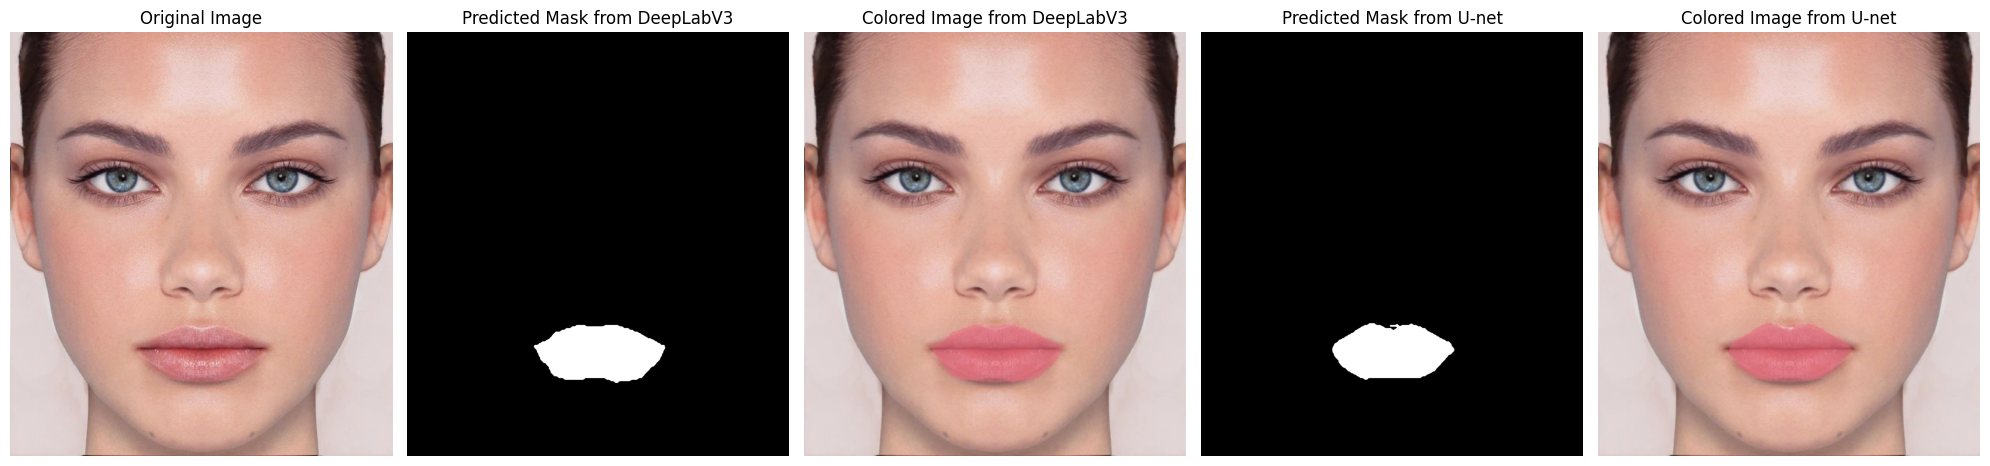

In [36]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Load model
MODEL_PATH1 = '/content/drive/MyDrive/modelv1.pth'
model1 = torch.load(MODEL_PATH1, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model1.eval()

MODEL_PATH2 = '/content/drive/MyDrive/model1.pth'
model2 = torch.load(MODEL_PATH2, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model2.eval()

# Load and preprocess the image
IMG_SIZE = 256
print("Please enter the file path to the image you want to try on lipstick:")
IMAGE_PATH = input()

image = cv2.imread(IMAGE_PATH)
original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(original_image, (IMG_SIZE, IMG_SIZE))

# Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_tensor = transform(resized_image).unsqueeze(0)
input_tensor = input_tensor.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Predict mask from both models
with torch.no_grad():
    output1 = model1(input_tensor)
    mask1 = output1.squeeze().cpu().numpy()

    output2 = model2(input_tensor)
    mask2 = output2.squeeze().cpu().numpy()

# Process the masks
def process_mask(mask):
    binary_mask = (mask > 0.2).astype(np.uint8)
    binary_mask_resized = cv2.resize(binary_mask, (original_image.shape[1], original_image.shape[0]))
    smoothed_mask = cv2.GaussianBlur(binary_mask_resized.astype(np.float32), (9, 9), 2)
    smoothed_mask = (smoothed_mask > 0.5).astype(np.uint8)
    return smoothed_mask

smoothed_mask1 = process_mask(mask1)
smoothed_mask2 = process_mask(mask2)

# Coloring function
def coloring_lip(imgOriginal, mask, r, g, b):
    img = imgOriginal.copy()
    new_color = np.array([r, g, b], dtype=np.uint8)
    img[mask == 1] = new_color
    img = cv2.GaussianBlur(img, (5, 5), 0)
    cv2.addWeighted(img, 0.6, imgOriginal, 0.4, 0, img)
    return img

# Áp dụng hàm coloring_lip cho cả hai mask
colored_images = []
while True:
    print("What color do you want to try on:"
          + "\n1. Punch - #dc3753" + "\n2. Rose - #e56d7e"
          + "\n3. Brick red - #8b160e" + "\n4. Dusty rose - #b8696a"
          + "\n5. Nude - #ccac9e" + "\n6. Royal blue - #313456")

    color_choice = input()
    if color_choice == "1":
        colored_image1 = coloring_lip(original_image, smoothed_mask1, 220, 55, 83)
        colored_image2 = coloring_lip(original_image, smoothed_mask2, 220, 55, 83)
    elif color_choice == "2":
        colored_image1 = coloring_lip(original_image, smoothed_mask1, 229, 109, 126)
        colored_image2 = coloring_lip(original_image, smoothed_mask2, 229, 109, 126)
    elif color_choice == "3":
        colored_image1 = coloring_lip(original_image, smoothed_mask1, 139, 22, 14)
        colored_image2 = coloring_lip(original_image, smoothed_mask2, 139, 22, 14)
    elif color_choice == "4":
        colored_image1 = coloring_lip(original_image, smoothed_mask1, 184, 105, 106)
        colored_image2 = coloring_lip(original_image, smoothed_mask2, 184, 105, 106)
    elif color_choice == "5":
        colored_image1 = coloring_lip(original_image, smoothed_mask1, 204, 172, 158)
        colored_image2 = coloring_lip(original_image, smoothed_mask2, 204, 172, 158)
    elif color_choice == "6":
        colored_image1 = coloring_lip(original_image, smoothed_mask1, 49, 52, 86)
        colored_image2 = coloring_lip(original_image, smoothed_mask2, 49, 52, 86)
    else:
        print("Please enter a valid option from 1 to 6")
        continue

    # Hiển thị kết quả
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(smoothed_mask1, cmap='gray')
    ax[1].set_title('Predicted Mask from DeepLabV3')
    ax[1].axis('off')

    ax[2].imshow(colored_image1)
    ax[2].set_title('Colored Image from DeepLabV3')
    ax[2].axis('off')

    ax[3].imshow(smoothed_mask2, cmap='gray')
    ax[3].set_title('Predicted Mask from U-net')
    ax[3].axis('off')

    ax[4].imshow(colored_image2)
    ax[4].set_title('Colored Image from U-net')
    ax[4].axis('off')

    plt.tight_layout()
    plt.show()
    break